In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2
import os

import util_functions as fs
import imp
imp.reload(fs)

%matplotlib inline

In [2]:
#Read Image
sheets = fs.get_images('./data/Tab_Butterfly-Waltz-Ukulele', resize_factor=1.0, threshold=200)

>>> Folder : ./data/Tab_Butterfly-Waltz-Ukulele : 2 files
01 : ./data/Tab_Butterfly-Waltz-Ukulele/p1.jpg : (2339, 1653)
02 : ./data/Tab_Butterfly-Waltz-Ukulele/p2.jpg : (2339, 1653)
>>> Inverse binary thresholding with threshold value 200


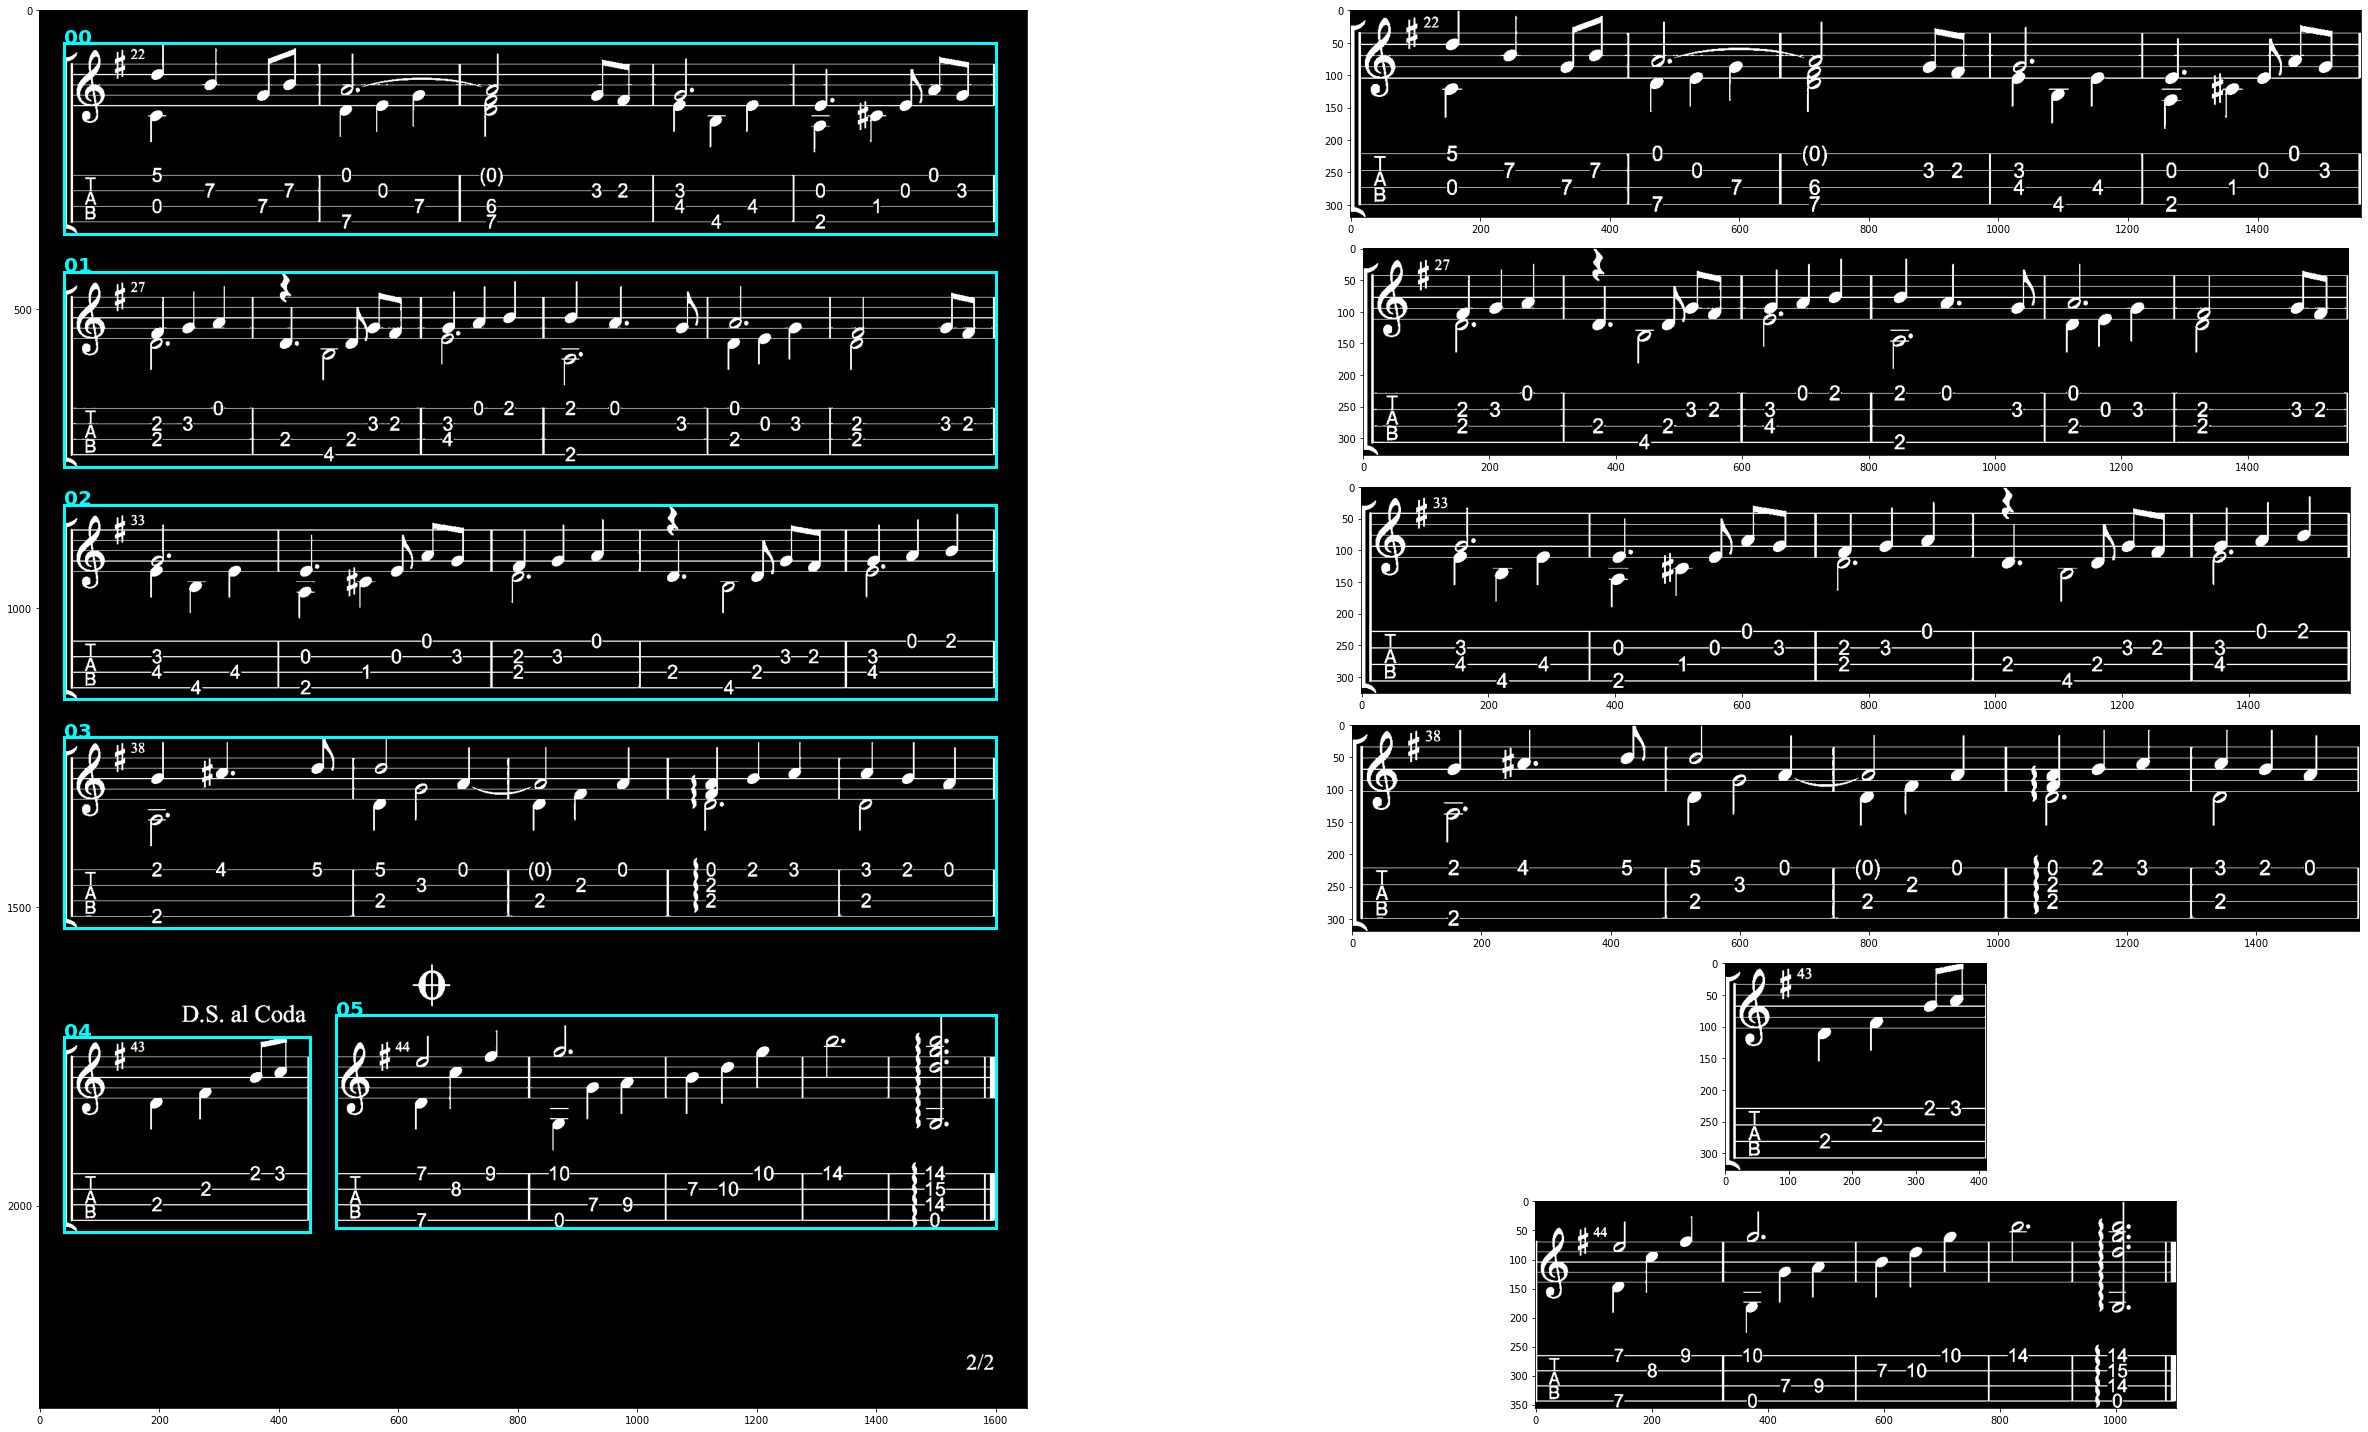

In [3]:
sample_image = sheets[1]

main_components, pos, _ = fs.get_main_components(sample_image)
row = len(main_components)

fig = plt.figure(figsize=(40,20))
ax = plt.subplot2grid((row, 2), (0, 0), rowspan=row)
ax.imshow(sample_image, cmap='gray')
for i, (x, y, w, h, area) in enumerate(pos):  #Highlighting
    ax.add_patch(patches.Rectangle((x, y), w, h, edgecolor='cyan', fill=False, linewidth=3))
    ax.text(x, y, f'{i:02d}', color='cyan', fontsize=20, fontweight='bold')
    
for i in range(len(main_components)):
    ax = plt.subplot2grid((row, 2), (i, 1))
    ax.imshow(main_components[i], cmap='gray')
    
fig.set_tight_layout(True)
plt.show() 

In [4]:
clef_paths = {
    "treble": [
        "./data/symbols/clef/treble_1.jpg",
        "./data/symbols/clef/treble_2.jpg"
    ],
    "bass": [
        "./data/symbols/clef/bass_1.jpg"
    ]
}

clef_imgs = {
    "treble": [fs.get_images(clef_file, resize_factor=1.0, threshold=200) for clef_file in clef_paths["treble"]],
    "bass": [fs.get_images(clef_file, resize_factor=1.0, threshold=200) for clef_file in clef_paths["bass"]]
}



>>> File : ./data/symbols/clef/treble_1.jpg
01 : ./data/symbols/clef/treble_1.jpg : (155, 60)
>>> Inverse binary thresholding with threshold value 200
>>> File : ./data/symbols/clef/treble_2.jpg
01 : ./data/symbols/clef/treble_2.jpg : (162, 54)
>>> Inverse binary thresholding with threshold value 200
>>> File : ./data/symbols/clef/bass_1.jpg
01 : ./data/symbols/clef/bass_1.jpg : (86, 45)
>>> Inverse binary thresholding with threshold value 200


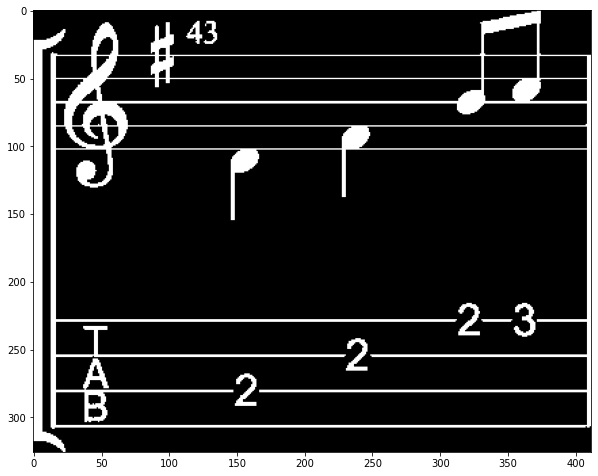

In [5]:
sample_component = main_components[4]

fs.plot_single_image(sample_component, off_axis=False)

In [6]:
component_height, component_width = sample_component.shape
templates = clef_imgs["treble"]

best_location_count = -1
best_locations = []
best_scale = 1

min_scale = 60
max_scale = 110
scale_interval = 2


scale_list = [i/100 for i in range(min_scale, max_scale, scale_interval)]


for scale in scale_list:
    locations = []
    location_count = 0
    
    for i, template in enumerate(templates):
        template_height, template_width = template.shape
        if (scale*template_width > component_width) or (scale*template_height > component_height):
            continue;
            
        template = cv2.resize(template, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
        result = cv2.matchTemplate(sample_component, template, cv2.TM_CCOEFF_NORMED)
        print(np.max(result))
        result = np.where(result>=0.7)
        location_count += len(result[0])
        locations += [result]
        print(f'Scale : {scale:.2f} >> hits : {location_count}')
        
    if (location_count > best_location_count):
        print('update')
        best_location_count = location_count
        best_locations = locations
        best_scale = scale
print(best_locations, best_scale)

0.3737063
Scale : 0.60 >> hits : 0
0.25668317
Scale : 0.60 >> hits : 0
update
0.3969
Scale : 0.62 >> hits : 0
0.3437091
Scale : 0.62 >> hits : 0
0.4185675
Scale : 0.64 >> hits : 0
0.29241642
Scale : 0.64 >> hits : 0
0.437837
Scale : 0.66 >> hits : 0
0.3043876
Scale : 0.66 >> hits : 0
0.454783
Scale : 0.68 >> hits : 0
0.32601795
Scale : 0.68 >> hits : 0
0.5095103
Scale : 0.70 >> hits : 0
0.32125354
Scale : 0.70 >> hits : 0
0.5580639
Scale : 0.72 >> hits : 0
0.3342156
Scale : 0.72 >> hits : 0
0.6233904
Scale : 0.74 >> hits : 0
0.34557205
Scale : 0.74 >> hits : 0
0.6779483
Scale : 0.76 >> hits : 0
0.36747098
Scale : 0.76 >> hits : 0
0.7051463
Scale : 0.78 >> hits : 1
0.39187422
Scale : 0.78 >> hits : 1
update
0.71047837
Scale : 0.80 >> hits : 1
0.44187793
Scale : 0.80 >> hits : 1
0.66708106
Scale : 0.82 >> hits : 0
0.3709131
Scale : 0.82 >> hits : 0
0.63544655
Scale : 0.84 >> hits : 0
0.32101294
Scale : 0.84 >> hits : 0
0.51656234
Scale : 0.86 >> hits : 0
0.2632471
Scale : 0.86 >> hits : 

In [7]:
image = sample_component
templates = clef_imgs["treble"]
scale_list = np.arange(30, 120, 2)/100.

best_score, best_scale, best_score_idx, best_template = -1, -1, None, None
obj_info = None
score_log = [[] for i in range(len(templates))]

image_height, image_width = image.shape

for i, template_ in enumerate(templates):
    template_height, template_width = template_.shape
    for scale in scale_list:
        if (scale*template_width > image_width) or (scale*template_height > image_height):
            break
        template = cv2.resize(template_, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
        result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

        best_idx = np.unravel_index(np.argmax(result), result.shape)
        score_log[i].append(result[best_idx])

        if best_score < result[best_idx]:
            best_score = result[best_idx]
            best_scale = scale
            best_score_idx = best_idx
            best_template = i
            obj_info = template.shape
            
            
print(best_score, best_score_idx, obj_info, best_scale, best_template, sep='\t')

0.71047837	(5, 22)	(124, 48)	0.8	0


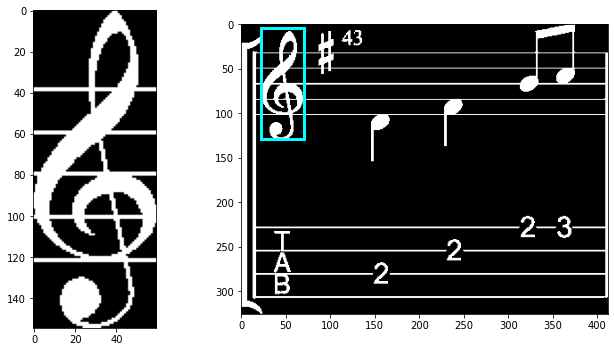

In [8]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(templates[best_template], cmap='gray')
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(image, cmap='gray')
ax2.add_patch(patches.Rectangle(best_score_idx[::-1], *obj_info[::-1], edgecolor='cyan', fill=False, linewidth=3))
    
fig.set_tight_layout(True)
plt.show() 

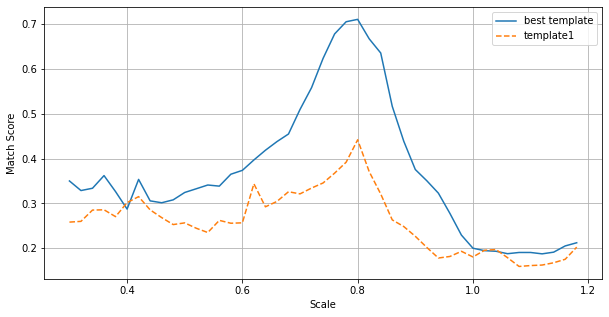

In [9]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
for i in range(len(templates)):
    if i != best_template:
        ax.plot(scale_list, score_log[i], '--', label=f'template{i}')
    else:
        ax.plot(scale_list, score_log[i], '-', label='best template')
        
ax.legend(); ax.grid()
ax.set_xlabel('Scale')
ax.set_ylabel('Match Score')
plt.show()